In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# we need to fit model with sequence of tokens with specific length
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
# normal LSTM/GRU and the Version with Cuda
from keras.layers import Dense, Embedding, GRU, LSTM, Dropout, Bidirectional
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, rmsprop

# keras wrapper for k-fold cross-validation
from keras.wrappers.scikit_learn import KerasClassifier
# normsl cross validation
from sklearn.model_selection import cross_val_score, train_test_split
# cross validation for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['spam.csv']


In [11]:
x_raw = []
y_raw = []

with open("../input/spam.csv", encoding = "ISO-8859-1") as f:
    for line in f:
        y_raw.append(line.split()[0])
        x_raw.append(' '.join(i for i in line.split()[1:]))

In [12]:
y = [1 if i=='ham' else 0 for i in y_raw]

print(max(len(s) for s in x_raw))
print(min(len(s)for s in x_raw))
sorted_X = sorted(len(s) for s in x_raw)
print(sorted_X[len(sorted_X) // 2])

909
0
60


In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_raw)
sequences = tokenizer.texts_to_sequences(x_raw)

vocab_size = len(tokenizer.word_index)+1
print(vocab_size)

8734


In [14]:
# divide sum of length of all sequences by number of all sequences to find averge length of each sequence
sum([len(x) for x in sequences]) // len(sequences)

14

In [15]:
pad = 'post' 
max_len = 25
embedding_size = 100
batch_size = 20
sequences = pad_sequences(sequences, maxlen=max_len, padding=pad, truncating=pad)
sequences.shape

X_train, X_test, y_train, y_test = train_test_split(sequences, y, test_size = 0.2, random_state= 0)

* **LSTM MODEL**

In [16]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
model.add(Dropout(0.8))
model.add(LSTM(140, return_sequences=False))
model.add(Dropout(0.8))
model.add(Dense(1, activation='sigmoid', name='Classification'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 100)           873400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 25, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 140)               134960    
_________________________________________________________________
dropout_4 (Dropout)          (None, 140)               0         
_________________________________________________________________
Classification (Dense)       (None, 1)                 141       
Total params: 1,008,501
Trainable params: 1,008,501
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#save_best = ModelCheckpoint('SpamDetection.hdf', save_best_only=True, monitor='val_acc', mode='max')
# callback_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [19]:
# Uses Automatic Verification Datasets (fastest option)
# model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.1, callbacks=[callback_early_stopping])
n_epochs = 10
results = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.2, verbose=1)


Train on 3568 samples, validate on 892 samples
Epoch 1/10
3568/3568 [==============================] - 10s 3ms/step - loss: 1.2624e-05 - acc: 1.0000 - val_loss: 2.1079e-07 - val_acc: 1.0000
Epoch 2/10
3568/3568 [==============================] - 10s 3ms/step - loss: 1.3175e-05 - acc: 1.0000 - val_loss: 1.5894e-07 - val_acc: 1.0000
Epoch 3/10
3568/3568 [==============================] - 10s 3ms/step - loss: 8.5477e-06 - acc: 1.0000 - val_loss: 1.3593e-07 - val_acc: 1.0000
Epoch 4/10
3568/3568 [==============================] - 10s 3ms/step - loss: 1.2147e-05 - acc: 1.0000 - val_loss: 1.1333e-07 - val_acc: 1.0000
Epoch 5/10
3568/3568 [==============================] - 10s 3ms/step - loss: 5.7093e-06 - acc: 1.0000 - val_loss: 1.0872e-07 - val_acc: 1.0000
Epoch 6/10
3568/3568 [==============================] - 11s 3ms/step - loss: 4.9057e-06 - acc: 1.0000 - val_loss: 1.0781e-07 - val_acc: 1.0000
Epoch 7/10
3568/3568 [==============================] - 10s 3ms/step - loss: 4.2114e-06 - acc: 

In [20]:
# model.load_weights(filepath='SpamDetection.hdf')
eval_ = model.evaluate(X_test, y_test)
print(eval_[0], eval_[1]) # loss / accuracy

1115/1115 [==============================] - 1s 528us/step
1.0163669134452385e-07 1.0


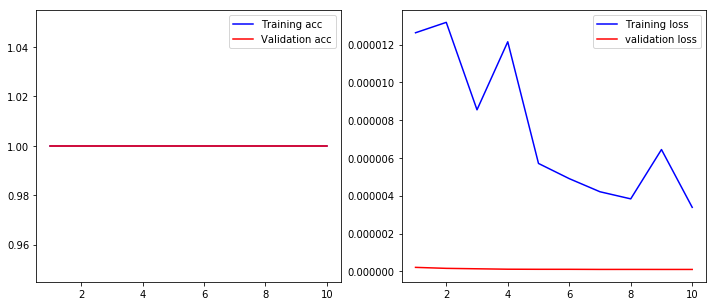

In [21]:
def plot_model(result):
    acc = result.history['acc']
    val_acc = result.history['val_acc']
    loss = result.history['loss']
    val_loss = result.history['val_loss']
    x = range(1, len(acc)+1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label= 'Validation acc')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='validation loss')
    plt.legend()
    
plot_model(results)

* **GRU MODEL**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 25, 100)           873400    
_________________________________________________________________
dropout_6 (Dropout)          (None, 25, 100)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 140)               101220    
_________________________________________________________________
dropout_7 (Dropout)          (None, 140)               0         
_________________________________________________________________
Classification (Dense)       (None, 1)                 141       
Total params: 974,761
Trainable params: 974,761
Non-trainable params: 0
_________________________________________________________________
Train on 3568 samples, validate on 892 samples
Epoch 1/10
3568/3568 [==============================] - 11s 3ms/step - loss: 0.0470 - acc

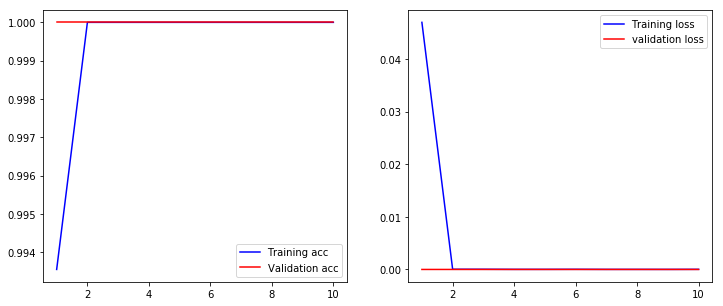

In [23]:
model1 = Sequential()
model1.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
model1.add(Dropout(0.8))
model1.add(GRU(140, return_sequences=False))
model1.add(Dropout(0.86))
model1.add(Dense(1, activation='sigmoid', name='Classification'))
model1.summary()

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
results1 = model1.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.2)

eval_ = model1.evaluate(X_test, y_test)
print(eval_[0], eval_[1]) # loss / accuracy

plot_model(results1)

* **Bidirectional LSTM MODEL**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 25, 100)           873400    
_________________________________________________________________
dropout_8 (Dropout)          (None, 25, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 280)               269920    
_________________________________________________________________
dropout_9 (Dropout)          (None, 280)               0         
_________________________________________________________________
Classification (Dense)       (None, 1)                 281       
Total params: 1,143,601
Trainable params: 1,143,601
Non-trainable params: 0
_________________________________________________________________
Train on 3568 samples, validate on 892 samples
Epoch 1/10
3568/3568 [==============================] - 17s 5ms/step - loss: 0.0328 -

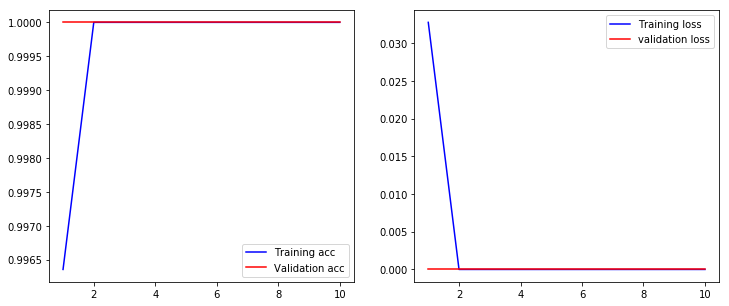

In [24]:
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
model2.add(Dropout(0.8))
model2.add(Bidirectional(LSTM(140, return_sequences=False)))
model2.add(Dropout(0.8))
model2.add(Dense(1, activation='sigmoid', name='Classification'))
model2.summary()

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

results2 = model2.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.2)

eval_ = model2.evaluate(X_test, y_test)
print(eval_[0], eval_[1]) # loss / accuracy

plot_model(results2)

* **CNN MODEL**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 25, 100)           873400    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 23, 128)           38528     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 128)            49280     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
__________

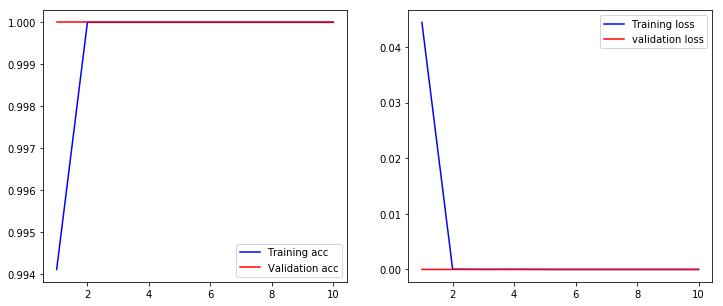

In [25]:
from keras.layers import Conv1D, MaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D

n_epochs = 10
model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
model3.add(Conv1D(128, 3, activation='relu'))
model3.add(MaxPool1D(3))
model3.add(Dropout(0.2))
model3.add(Conv1D(128, 3, activation='relu'))
model3.add(GlobalMaxPooling1D())
model3.add(Dropout(0.2))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.2))
model3.summary()
model3.add(Dense(1, activation='sigmoid'))


model3.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
result3 = model3.fit(X_train, y_train, batch_size = batch_size, epochs=n_epochs, validation_split=0.2, verbose=1)
eval_ = model3.evaluate(X_test, y_test)
print(eval_[0], eval_[1]) # loss / accuracy

plot_model(result3)

* **CNN with Glove Model**

In [26]:
# word2vec = {}
# f = open('glove.6B/glove.6B.100d.txt', encoding="utf-8")
# for line in f:
#     values = line.split()
#     word = values[0]
#     vec = np.asarray(values[1:], dtype='float32')
#     word2vec[word] = vec
    
# print(len(word2vec))

# embedding_matrix = np.zeros((vocab_size, embedding_size))

# for word,i in  tokenizer.word_index.items():
#     if i < vocab_size:
#         embedding_vector = word2vec.get(word)
#         if embedding_vector is not None:
#          # words not in the glove will be set to zero   
#             embedding_matrix[i] = embedding_vector
            

# n_epochs = 20
# model4 = Sequential()
# model4.add(Embedding(input_dim=vocab_size, output_dim=embedding_size,weights = [embedding_matrix], input_length=max_len, trainable=True))
# model4.add(Conv1D(128, 3, activation='relu'))
# model4.add(MaxPool1D(3))
# model4.add(Dropout(0.2))
# model4.add(Conv1D(128, 3, activation='relu'))
# model4.add(GlobalMaxPooling1D())
# model4.add(Dropout(0.2))
# model4.add(Dense(64, activation='relu'))
# model4.add(Dropout(0.2))
# model4.add(Dense(32, activation='relu'))
# model4.add(Dropout(0.2))
# model4.add(Dense(16, activation='relu'))
# model4.add(Dropout(0.2))
# model4.summary()
# model4.add(Dense(1, activation='sigmoid'))


# model4.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
# save_best = ModelCheckpoint('SMS.hdf', save_best_only=True, monitor='val_acc', mode='max')
# result4 = model4.fit(X_train, y_train, batch_size = batch_size, epochs=n_epochs, validation_split=0.2, verbose=1,  callbacks=[save_best])
# eval_ = model4.evaluate(X_test, y_test)
# print(eval_[0], eval_[1]) # loss / accuracy

# plot_model(result4)

# Results

corpus : 9000 words

Results

Model                Accuracy
 
*  LSTM  :              100%
*  Bidirectional LSTM : 100%
*  GRU :                100%
*  CNN :                100%
*  Glove-CNN :          